<a href="https://colab.research.google.com/github/NirajBagh/Drift-Detection-in-Industrial-Running-Machines/blob/main/Drift_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift Detection in Industrial Running Machines

Drift detection in industrial machines is crucial for several reasons, primarily to ensure the efficient operation, reliability, and safety of the equipment. Drift detection helps in identifying abnormal patterns or deviations in machine behavior (e.g., vibration, temperature, or power consumption). Early detection allows operators to perform preventive maintenance, reducing downtime and preventing catastrophic failures.
Continuous monitoring and detecting changes in machine performance can signal when machinery is not operating at optimal efficiency. Adjustments can then be made to improve performance, saving energy and resources.
 Early detection of changes in machine performance ensures that corrective actions are taken before a machine failure occurs, minimizing production interruptions.

This notebook is intended to illustrate the change detection of industrial machinery by walking through a real life dataset of bearing vibration data.

# The Dataset

The dataset is sourced from the NASA repo https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/.

Dataset Citation : J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

The Nasa data set describes a test-to-failure experiment. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point.

In [1]:
# Common imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/Machine life detection/2nd_test'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs], ignore_index=False)

# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [4]:
# Check - Begining of Data
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [5]:
# Check - End of Data
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


In [6]:
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 985


# Visualization of Data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

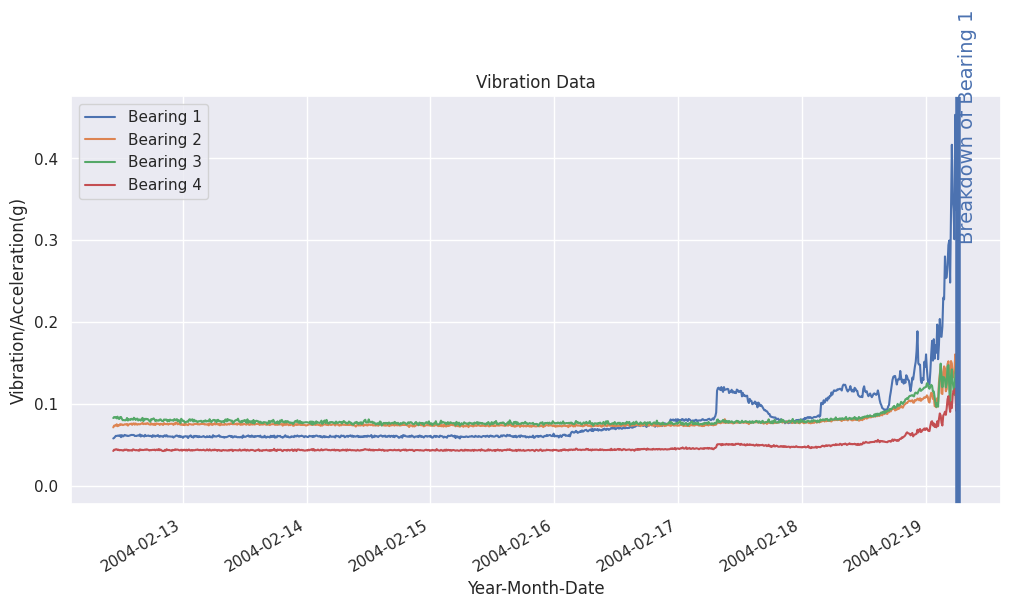

In [7]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

# Drift Detection using DeepCheck Technique

Drift is simply a change in the distribution of data over time, and it is also one of the top reasons why machine learning model’s performance degrades over time. Prediction drift is when drift occurs in the prediction itself. Calculating prediction drift is especially useful in cases in which labels are not available for the test dataset, and so a drift in the predictions is a direct indication that a change that happened in the data has affected the model’s predictions. The deepche used Kolmogorov-Smirnov (KS) test to detect drift in the data.
The Kolmogorov-Smirnov (KS) test is a non-parametric statistical test used to determine whether two samples come from the same distribution or whether a sample follows a specified probability distribution. It compares the empirical distribution functions of the two samples or a sample against a reference distribution.

In [8]:
!pip install deepchecks

In [9]:
!pip show deepchecks scikit-learn

Name: deepchecks
Version: 0.18.1
Summary: Package for validating your machine learning model and data
Home-page: https://github.com/deepchecks/deepchecks
Author: deepchecks
Author-email: info@deepchecks.com
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: beautifulsoup4, category-encoders, ipykernel, ipython, ipywidgets, jsonpickle, jupyter-server, matplotlib, numpy, pandas, plotly, PyNomaly, requests, scikit-learn, scipy, statsmodels, tqdm, typing-extensions
Required-by: 
---
Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, category-encoders, deepchecks, fastai, imbalanced-learn, librosa, mlxtend, sklearn-pandas, yellowbrick


In [10]:
!pip install --upgrade scikit-learn deepchecks

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)


In [11]:
!pip uninstall deepchecks scikit-learn -y

Found existing installation: deepchecks 0.18.1
Uninstalling deepchecks-0.18.1:
  Successfully uninstalled deepchecks-0.18.1
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2


In [12]:
!pip install deepchecks scikit-learn

  Using cached deepchecks-0.18.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached deepchecks-0.18.1-py3-none-any.whl (7.8 MB)
Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)


# Create Referenace and Analysis Period

In [13]:
data=pd.read_csv("/content/merged_dataset_BearingTest_2.csv")

In [14]:
data.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
1,2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
3,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
4,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [15]:
data['timestamp']=data['Unnamed: 0']

In [16]:
# Dropping a column
data=data.drop(columns=['Unnamed: 0'])

# Calculate Statistical Features

In [17]:
def compute_skewness(x):
    n = len(x)
    third_moment = np.sum((x - np.mean(x))**3) / n
    s_3 = np.std(x, ddof = 1) ** 3
    return third_moment/s_3

In [18]:
def compute_kurtosis(x):
    n = len(x)
    fourth_moment = np.sum((x - np.mean(x))**4) / n
    s_4 = np.std(x, ddof = 1) ** 4
    return fourth_moment / s_4 - 3

In [19]:
# Initialize an empty DataFrame
Time_feature_matrix = pd.DataFrame()
test_set = 2
bearing_no = 1  # Provide the Bearing number [1,2,3,4] of the Test set
path = r'/content/drive/MyDrive/Machine life detection/2nd_test'

for filename in os.listdir(path):
    dataset = pd.read_csv(os.path.join(path, filename), sep='\t', header=None)
    bearing_data = np.array(dataset.iloc[:, bearing_no - 1])

    # Create a feature matrix
    feature_matrix = np.zeros((1, 9))
    temp = bearing_data
    feature_matrix[0, 0] = np.max(temp)
    feature_matrix[0, 1] = np.min(temp)
    feature_matrix[0, 2] = np.mean(temp)
    feature_matrix[0, 3] = np.std(temp, ddof=1)
    feature_matrix[0, 4] = np.sqrt(np.mean(temp ** 2))
    feature_matrix[0, 5] = compute_skewness(temp)  # Assuming this is a valid function
    feature_matrix[0, 6] = compute_kurtosis(temp)  # Assuming this is a valid function
    feature_matrix[0, 7] = feature_matrix[0, 0] / feature_matrix[0, 4]
    feature_matrix[0, 8] = feature_matrix[0, 4] / feature_matrix[0, 2]

    # Create a DataFrame for the current file
    df = pd.DataFrame(feature_matrix)
    df.index = [filename[:-3]]  # Set index based on filename

    # Use pd.concat to concatenate the DataFrames
    Time_feature_matrix = pd.concat([Time_feature_matrix, df])

# Display the resulting DataFrame
print(Time_feature_matrix)

                      0      1         2         3         4         5  \
2004.02.12.12.52  0.422 -0.383 -0.002372  0.079183  0.079217  0.024886   
2004.02.12.11.02  0.608 -0.576 -0.002277  0.078693  0.078724  0.041483   
2004.02.12.12.02  0.378 -0.344 -0.002097  0.075690  0.075718  0.046318   
2004.02.12.15.12  0.391 -0.344 -0.002356  0.078246  0.078280  0.033694   
2004.02.12.15.52  0.388 -0.344 -0.001880  0.077400  0.077421 -0.018265   
...                 ...    ...       ...       ...       ...       ...   
2004.02.19.03.32  1.162 -1.030 -0.001957  0.291652  0.291651 -0.027165   
2004.02.19.01.42  0.725 -0.862 -0.001916  0.202984  0.202988 -0.220118   
2004.02.19.05.02  4.998 -5.000  0.003389  0.672145  0.672137 -0.766011   
2004.02.19.03.52  1.086 -1.025 -0.001933  0.314813  0.314811  0.007877   
2004.02.19.06.02  3.501 -3.696 -0.001703  0.483844  0.483835 -0.377068   

                          6         7           8  
2004.02.12.12.52   0.550764  5.327141  -33.397776  
2004.02

In [20]:
Time_feature_matrix
Time_feature_matrix.columns = ['Max','Min','Mean','Std','RMS','Skewness','Kurtosis','Crest Factor','Form Factor']
Time_feature_matrix.index = pd.to_datetime(Time_feature_matrix.index, format='%Y.%m.%d.%H.%M')

Time_feature_matrix = Time_feature_matrix.sort_index()

Time_feature_matrix.to_csv('Time_feature_matrix_Bearing_{}_Test_{}.csv'.format(bearing_no,test_set))

Time_feature_matrix

,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-02-12 10:32:00,0.454,-0.386,-0.010196,0.073477,0.074179,0.083987,0.628408,6.120331,-7.275307
2004-02-12 10:42:00,0.369,-0.388,-0.002585,0.075340,0.075382,0.052138,0.647935,4.895038,-29.161382
2004-02-12 10:52:00,0.503,-0.400,-0.002484,0.076191,0.076230,0.032806,0.513132,6.598472,-30.688508
2004-02-12 11:02:00,0.608,-0.576,-0.002277,0.078693,0.078724,0.041483,1.157547,7.723217,-34.579322
2004-02-12 11:12:00,0.391,-0.391,-0.002404,0.078439,0.078474,0.028222,0.602825,4.982524,-32.645152
...,...,...,...,...,...,...,...,...,...
2004-02-19 05:42:00,4.998,-5.000,-0.002752,0.725014,0.725001,-0.510519,12.576183,6.893779,-263.426419
2004-02-19 05:52:00,2.688,-2.881,-0.004487,0.462001,0.462012,-0.325344,3.759312,5.818035,-102.977656
2004-02-19 06:02:00,3.501,-3.696,-0.001703,0.483844,0.483835,-0.377068,4.890985,7.235932,-284.094983
2004-02-19 06:12:00,0.005,0.000,0.001857,0.000987,0.002103,0.579656,3.636864,2.377543,1.132578


In [21]:
Time_feature_matrix=pd.read_csv("/content/Time_feature_matrix_Bearing_1_Test_2.csv")

In [22]:
Time_feature_matrix.head()

,Unnamed: 0,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
0,2004-02-12 10:32:00,0.454,-0.386,-0.010196,0.073477,0.074179,0.083987,0.628408,6.120331,-7.275307
1,2004-02-12 10:42:00,0.369,-0.388,-0.002585,0.075340,0.075382,0.052138,0.647935,4.895038,-29.161382
2,2004-02-12 10:52:00,0.503,-0.400,-0.002484,0.076191,0.076230,0.032806,0.513132,6.598472,-30.688508
3,2004-02-12 11:02:00,0.608,-0.576,-0.002277,0.078693,0.078724,0.041483,1.157547,7.723217,-34.579322
4,2004-02-12 11:12:00,0.391,-0.391,-0.002404,0.078439,0.078474,0.028222,0.602825,4.982524,-32.645152


In [23]:
reference_df1=Time_feature_matrix.iloc[0:100,1:10] # consider 1st 100 samples
analysis_df1=Time_feature_matrix.iloc[100:,1:10]

In [24]:
reference_df1.head()

,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
0,0.454,-0.386,-0.010196,0.073477,0.074179,0.083987,0.628408,6.120331,-7.275307
1,0.369,-0.388,-0.002585,0.075340,0.075382,0.052138,0.647935,4.895038,-29.161382
2,0.503,-0.400,-0.002484,0.076191,0.076230,0.032806,0.513132,6.598472,-30.688508
3,0.608,-0.576,-0.002277,0.078693,0.078724,0.041483,1.157547,7.723217,-34.579322
4,0.391,-0.391,-0.002404,0.078439,0.078474,0.028222,0.602825,4.982524,-32.645152


# Univariate Drift Analysis

In [25]:
from deepchecks.tabular.checks import FeatureDrift
check = FeatureDrift()
result = check.run(train_dataset=reference_df1, test_dataset=analysis_df1)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.
deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuris

In [26]:
# Access the 'value' attribute
value = result.value
print("Extracted Value:", value)

Extracted Value: {'Max': {'Drift score': 0.35723981900452484, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Min': {'Drift score': 0.3827149321266968, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Mean': {'Drift score': 0.1395475113122172, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Std': {'Drift score': 0.5101809954751131, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'RMS': {'Drift score': 0.5101809954751131, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Skewness': {'Drift score': 0.3286877828054299, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Kurtosis': {'Drift score': 0.34746606334841623, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Crest Factor': {'Drift score': 0.15977375565610863, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}, 'Form Factor': {'Drift score': 0.4163800904977375, 'Method': 'Kolmogorov-Smirnov', 'Importance': None}}


In [35]:
# Convert dictionary to pandas DataFrame
D_score= pd.DataFrame(value).T  # .T transposes the data to have the keys as row labels

# Display the table
print(D_score)

             Drift score              Method Importance
Max              0.35724  Kolmogorov-Smirnov       None
Min             0.382715  Kolmogorov-Smirnov       None
Mean            0.139548  Kolmogorov-Smirnov       None
Std             0.510181  Kolmogorov-Smirnov       None
RMS             0.510181  Kolmogorov-Smirnov       None
Skewness        0.328688  Kolmogorov-Smirnov       None
Kurtosis        0.347466  Kolmogorov-Smirnov       None
Crest Factor    0.159774  Kolmogorov-Smirnov       None
Form Factor      0.41638  Kolmogorov-Smirnov       None


In [49]:
result # it will give distribution plots for individual features with drift score

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Feature Drift

# Multivariate Drift Analysis

In [50]:
from deepchecks.tabular.checks import MultivariateDrift
check = MultivariateDrift()
result1 = check.run(train_dataset=reference_df1, test_dataset=analysis_df1)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.
deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuris

In [64]:
# Access the 'value' attribute
value = result1.value
print("Extracted Value:", value)

Extracted Value: {'domain_classifier_auc': 0.823888888888889, 'domain_classifier_drift_score': 0.647777777777778, 'domain_classifier_feature_importance': {'Std': 1.0, 'Max': 0.0, 'Min': -0.0, 'Mean': 0.0, 'RMS': -0.0, 'Skewness': -0.0, 'Kurtosis': -0.0, 'Crest Factor': 0.0, 'Form Factor': 0.0}}


In [65]:
# Convert dictionary to pandas DataFrame
D_score= pd.DataFrame(value).T  # .T transposes the data to have the keys as row labels

# Display the table
print(D_score)

                                      Crest Factor  Form Factor  Kurtosis  \
domain_classifier_auc                     0.823889     0.823889  0.823889   
domain_classifier_drift_score             0.647778     0.647778  0.647778   
domain_classifier_feature_importance      0.000000     0.000000 -0.000000   

                                           Max      Mean       Min       RMS  \
domain_classifier_auc                 0.823889  0.823889  0.823889  0.823889   
domain_classifier_drift_score         0.647778  0.647778  0.647778  0.647778   
domain_classifier_feature_importance  0.000000  0.000000 -0.000000 -0.000000   

                                      Skewness       Std  
domain_classifier_auc                 0.823889  0.823889  
domain_classifier_drift_score         0.647778  0.647778  
domain_classifier_feature_importance -0.000000  1.000000  


In [53]:
result1 # it will give distribution plots for multivarate with drift score

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Multivariate Drift

# Kolmogorov-Smirnov  Drift Detection using Sliding Window Technique

#1. Univariate Drift Detection

Univariate drift detection is a statistical technique used to identify changes in the distribution of a single variable over time. Unlike multivariate drift detection, which examines multiple variables simultaneously, univariate drift focuses on individual features or measurements.

In [31]:
pip install scipy

In [29]:
pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deepchecks 0.18.1 requires scipy<=1.10.1,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


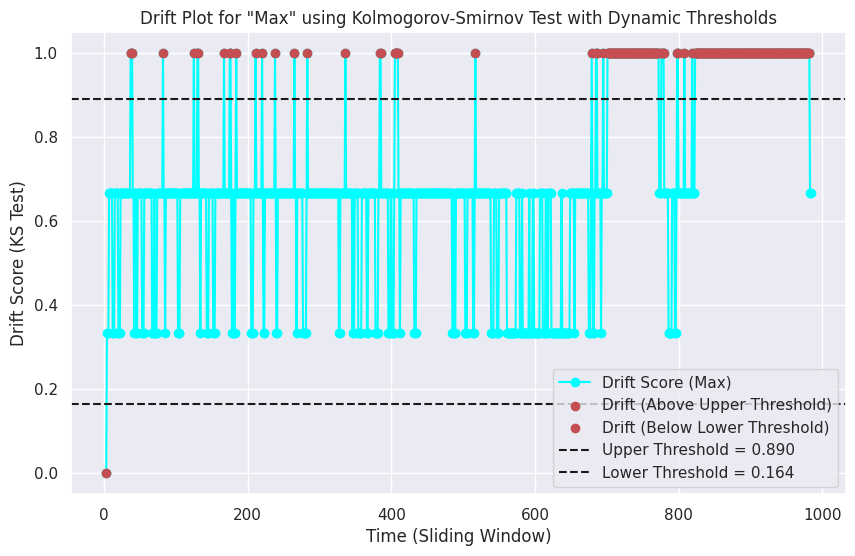

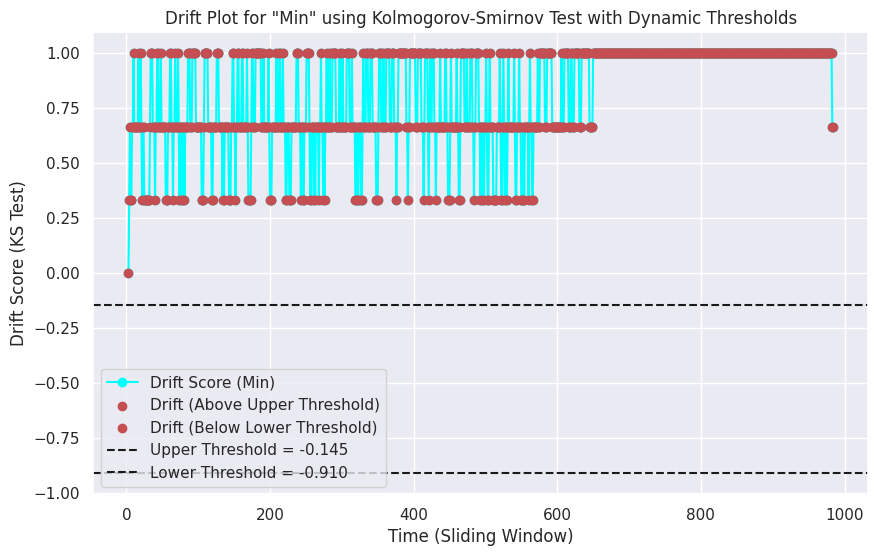

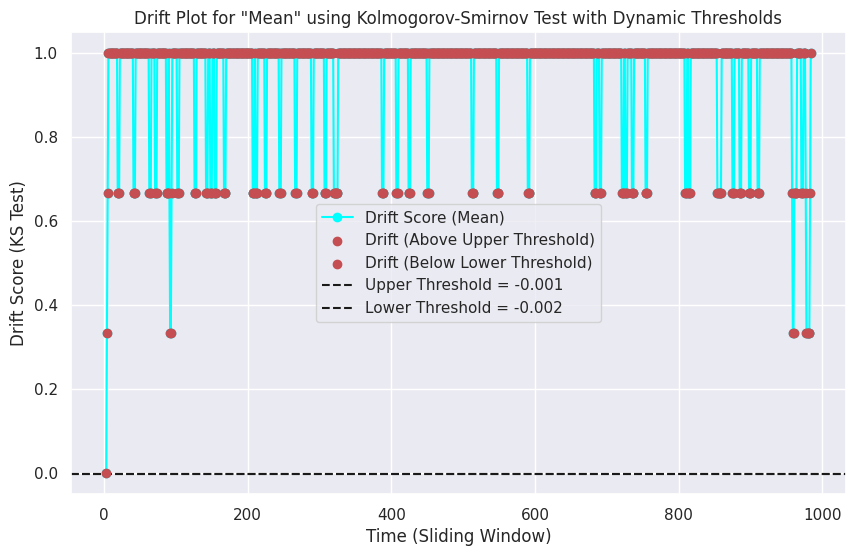

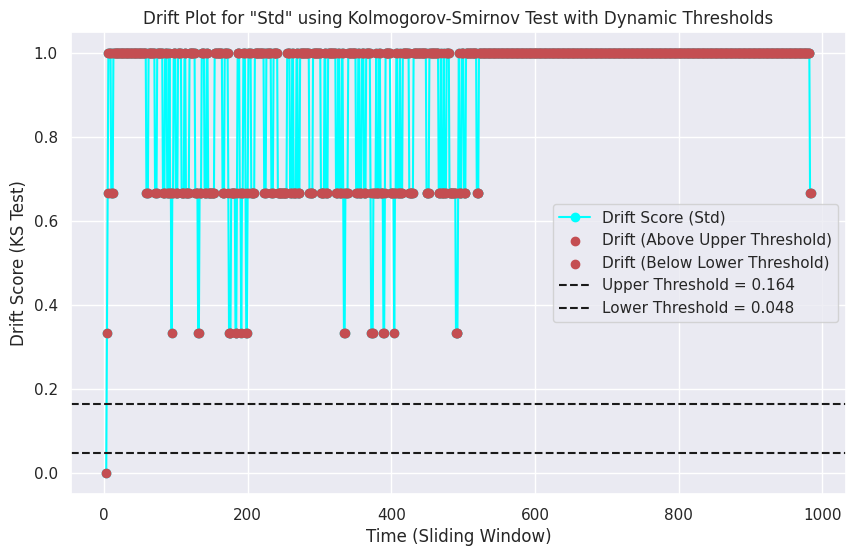

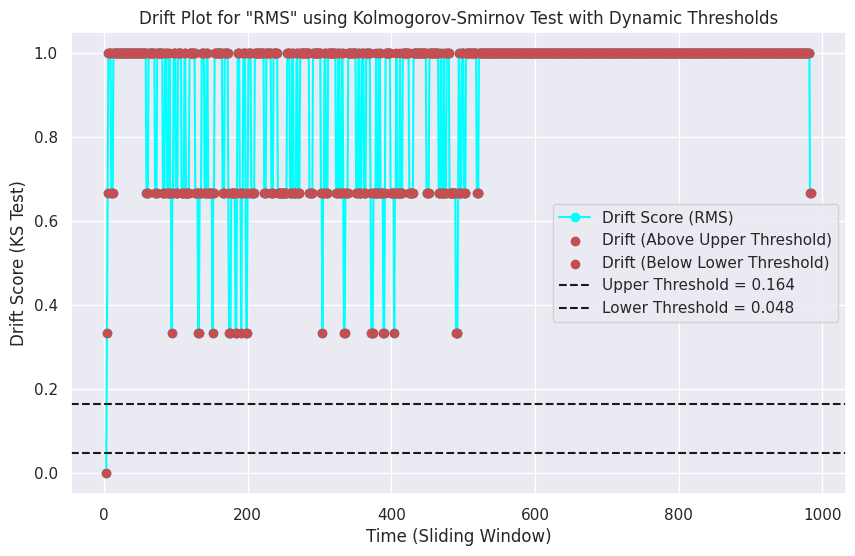

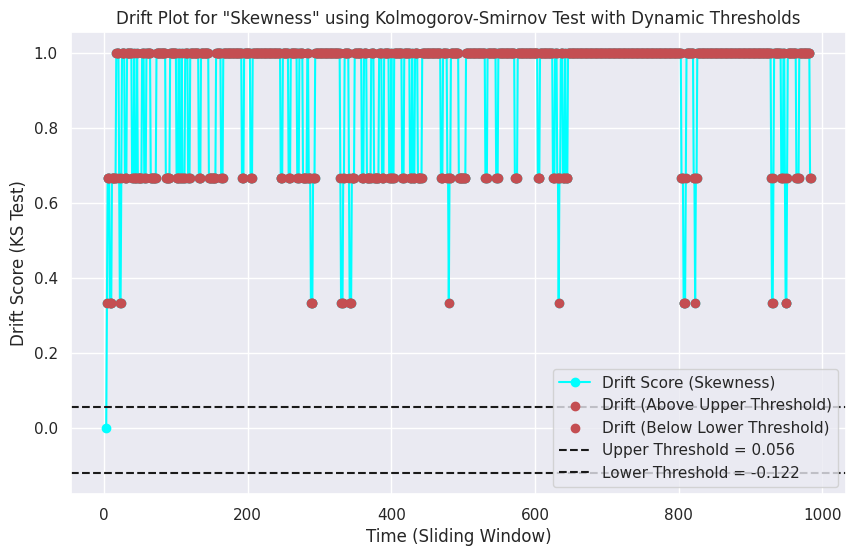

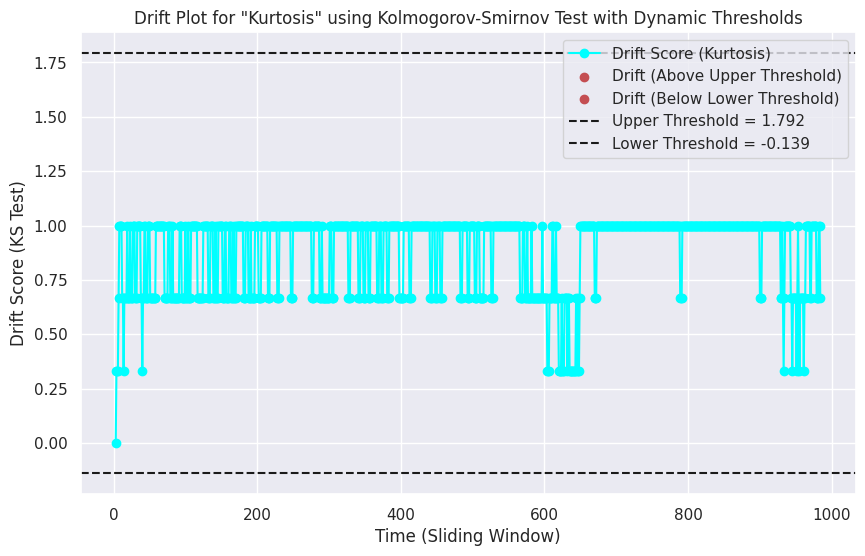

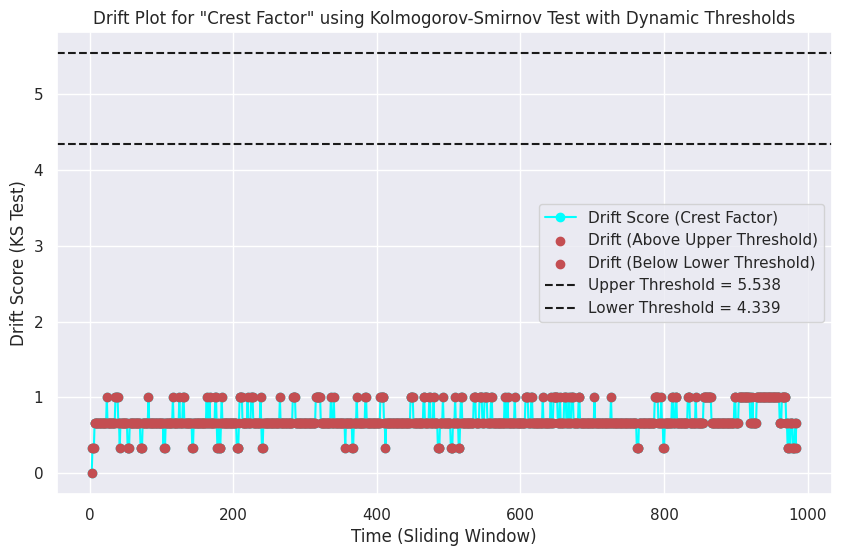

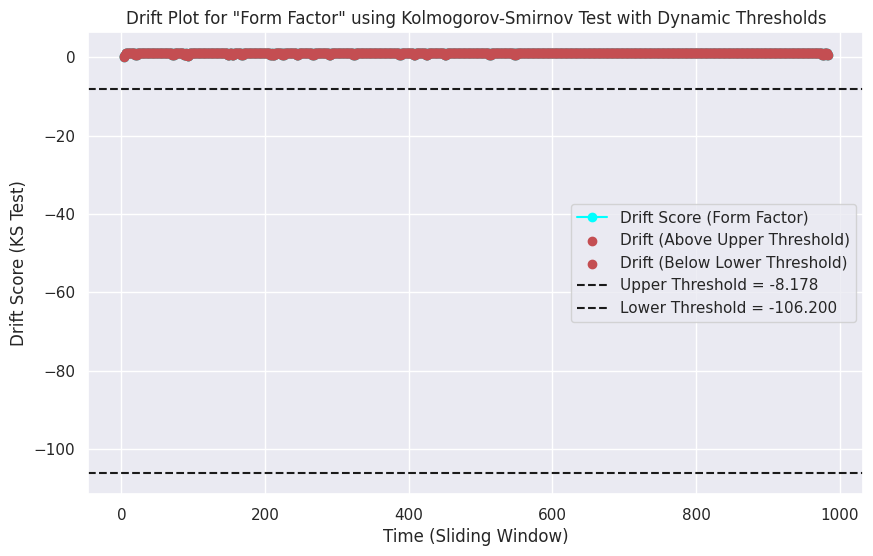

In [48]:
# Sliding window parameters
import pandas as pd
import numpy as np
from scipy.stats import kstest
import matplotlib.pyplot as plt
df=Time_feature_matrix.iloc[:,1:10]
window_size = 3  # Adjust window size as needed
step_size = 1  # Step size for the sliding window

# Define a function to calculate drift scores and plot results for each feature
def plot_drift_for_feature(feature_name):
    # Calculate mean and std for the current feature
    feature_values = df[feature_name]
    mean_feature = feature_values.mean()
    std_feature = feature_values.std()

    # Define dynamic thresholds based on (mean ± std)
    upper_threshold = mean_feature + std_feature
    lower_threshold = mean_feature - std_feature

    # Initialize a list to store drift scores
    drift_scores = []

    # Perform KS test using sliding window
    for start in range(0, len(df) - window_size + 1, step_size):
        window = feature_values[start:start + window_size]  # Current window
        reference = feature_values[:window_size]  # Reference window (first window)

        # Apply Kolmogorov-Smirnov test
        statistic, _ = kstest(window, reference)
        drift_scores.append(statistic)

    # Generate the x-axis values
    x_values = range(window_size, len(df) + 1)

    # Convert to NumPy array for convenience
    drift_scores = np.array(drift_scores)

    # Plot the drift scores
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, drift_scores, marker='o', color='cyan', label=f'Drift Score ({feature_name})')

    # Highlight points that exceed the dynamic thresholds
    drift_points_upper = drift_scores > upper_threshold
    drift_points_lower = drift_scores < lower_threshold
    plt.scatter(np.array(x_values)[drift_points_upper], drift_scores[drift_points_upper], color='r', label='Drift (Above Upper Threshold)', zorder=5)
    plt.scatter(np.array(x_values)[drift_points_lower], drift_scores[drift_points_lower], color='r', label='Drift (Below Lower Threshold)', zorder=5)

    # Plot dynamic threshold lines
    plt.axhline(y=upper_threshold, color='k', linestyle='--', label=f'Upper Threshold = {upper_threshold:.3f}')
    plt.axhline(y=lower_threshold, color='k', linestyle='--', label=f'Lower Threshold = {lower_threshold:.3f}')

    # Add labels and title
    plt.xlabel('Time (Sliding Window)')
    plt.ylabel('Drift Score (KS Test)')
    plt.title(f'Drift Plot for "{feature_name}" using Kolmogorov-Smirnov Test with Dynamic Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

# List of features to analyze
features = ['Max', 'Min', 'Mean', 'Std', 'RMS', 'Skewness', 'Kurtosis', 'Crest Factor', 'Form Factor']

# Loop through each feature and plot the drift results
for feature in features:
    plot_drift_for_feature(feature)

# 2. Multivariate Drift Detection with PCA

Multivariate detection with Principal Component Analysis (PCA) is a technique used to identify patterns, anomalies, or drifts in multivariate data. PCA helps in reducing the dimensionality of the dataset while preserving as much variance as possible. This is particularly useful when dealing with high-dimensional datasets where traditional analysis methods may struggle.

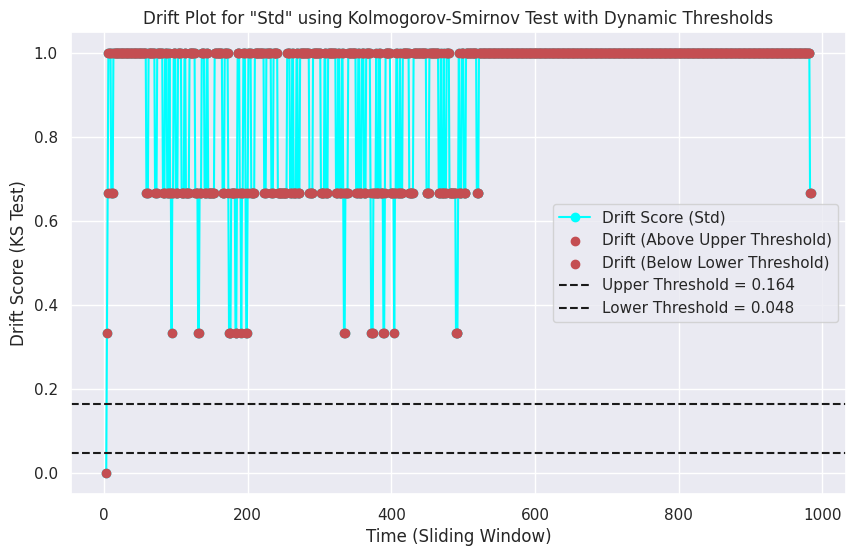

Top feature based on PCA: Std


In [63]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest
import matplotlib.pyplot as plt

# Step 1: Standardize the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Step 2: Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Step 3: Reconstruct the Data
reconstructed_data = pca.inverse_transform(principal_components)

# Step 4: Identify the Top Feature
# Get the loadings (components) for the first principal component
loadings = pca.components_[0]
feature_importance = pd.Series(loadings, index=df.columns)
top_feature = feature_importance.abs().idxmax()

# Step 5: Calculate Drift for the Selected Feature
def calculate_drift(feature_name):
    # Calculate mean and std for the selected feature
    feature_values = df[feature_name]
    mean_feature = feature_values.mean()
    std_feature = feature_values.std()

    # Define dynamic thresholds based on (mean ± std)
    upper_threshold = mean_feature + 1*std_feature
    lower_threshold = mean_feature - 1*std_feature

    # Initialize a list to store drift scores
    drift_scores = []

    # Perform KS test using sliding window
    window_size = 3
    for start in range(0, len(df) - window_size + 1):
        window = feature_values[start:start + window_size]  # Current window
        reference = feature_values[:window_size]  # Reference window (first window)

        # Apply Kolmogorov-Smirnov test
        statistic, _ = kstest(window, reference)
        drift_scores.append(statistic)

    # Generate the x-axis values
    x_values = range(window_size, len(df) + 1)

    # Plot the drift scores
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, drift_scores, marker='o', color='cyan', label=f'Drift Score ({feature_name})')

    # Highlight points that exceed the dynamic thresholds
    drift_points_upper = np.array(drift_scores) > upper_threshold
    drift_points_lower = np.array(drift_scores) < lower_threshold
    plt.scatter(np.array(x_values)[drift_points_upper], np.array(drift_scores)[drift_points_upper], color='r', label='Drift (Above Upper Threshold)', zorder=5)
    plt.scatter(np.array(x_values)[drift_points_lower], np.array(drift_scores)[drift_points_lower], color='r', label='Drift (Below Lower Threshold)', zorder=5)

    # Plot dynamic threshold lines
    plt.axhline(y=upper_threshold, color='k', linestyle='--', label=f'Upper Threshold = {upper_threshold:.3f}')
    plt.axhline(y=lower_threshold, color='k', linestyle='--', label=f'Lower Threshold = {lower_threshold:.3f}')

    # Add labels and title
    plt.xlabel('Time (Sliding Window)')
    plt.ylabel('Drift Score (KS Test)')
    plt.title(f'Drift Plot for "{feature_name}" using Kolmogorov-Smirnov Test with Dynamic Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate drift for the top feature
calculate_drift(top_feature)

# Print results
print(f"Top feature based on PCA: {top_feature}")


The drift in the features is now clearly visible through the change in the D score, while our earlier univariate approach detected few drift in features.

# Conclusion

With drift detection data, machine learning models can predict future failures or performance drops. This leads to more informed decision-making on equipment usage, maintenance schedules, and even the procurement of new machines. So, the change detection helps optimize industrial machine operations, reduce costs, ensure safety, and increase equipment reliability and lifespan, making it a critical component of modern industrial systems.